In [1]:
#%pip install lyricsgenius

In [2]:
import lyricsgenius as lg
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
FOLDER = "data/"

## Data wrangling:
The final data frame **top10\_df** contains top 10 songs per year, sorted by **'Weeks on Chart'**, i.e. the number of weeks they've been on the Billboard chart.

In [4]:
filename = 'billboard.csv'
df = pd.read_csv(FOLDER+filename)
df['Year'] = pd.to_datetime(df['WeekID']).dt.year
df = df.rename(columns={"Week Position":"WeekPosition"})
df = df.drop_duplicates(['SongID'])
df.head()

,url,WeekID,WeekPosition,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Year
0,http://www.billboard.com/charts/hot-100/1963-0...,6/1/1963,11,Still,Bill Anderson,StillBill Anderson,1.0,17.0,11.0,8.0,1963
1,http://www.billboard.com/charts/hot-100/1967-0...,1/7/1967,11,Coming Home Soldier,Bobby Vinton,Coming Home SoldierBobby Vinton,1.0,17.0,11.0,8.0,1967
2,http://www.billboard.com/charts/hot-100/1971-0...,7/3/1971,11,She's Not Just Another Woman,The 8th Day,She's Not Just Another WomanThe 8th Day,1.0,17.0,11.0,8.0,1971
3,http://www.billboard.com/charts/hot-100/1975-1...,11/29/1975,11,Saturday Night,Bay City Rollers,Saturday NightBay City Rollers,1.0,17.0,11.0,8.0,1975
4,http://www.billboard.com/charts/hot-100/1979-0...,9/29/1979,11,Pop Muzik,M,Pop MuzikM,1.0,17.0,11.0,8.0,1979


In [5]:
df = df.sort_values(by='Weeks on Chart', ascending=False)
top10_df = df.groupby('Year').head(10)
top10_df = top10_df[['Song', 'Performer', 'Year']]
top10_df['Decade'] = (top10_df['Year']//10)*10
top10_df.head()

,Song,Performer,Year,Decade
167831,Eastside,"benny blanco, Halsey & Khalid",2019,2010
252653,Wait For You,Elliott Yamin,2007,2000
271215,Wildflower,Skylark,1973,1970
177187,Even Though I'm Leaving,Luke Combs,2019,2010
315541,Do Re Mi,blackbear,2017,2010


In [6]:
print("Total number of songs: ",len(top10_df))

Total number of songs:  630


(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([1958.        , 1958.98412698, 1959.96825397, 1960.95238095,
        1961.93650794, 1962.92063492, 1963.9047619 , 1964.88888889,
        1965.87301587, 1966.85714286, 1967.84126984, 1968.82539683,
        1969.80952381, 1970.79365079, 1971.77777778, 1972.76190476,
        1973.74603175, 1974.73015873, 1975.71428571, 1976.6984127 ,
        1977.68253968, 1978.66666667, 1979.65079365, 1980.63492063,
        1981.61904762, 1982.6031746 , 1983.58730159, 1984.57142857,
        1985.55555556, 1986.53968254, 1987.52380952, 1988.50793651,
        1989.49206349, 1990.47619048, 1991.46031746, 1992.44444444,
        1993.42857143, 1994.412

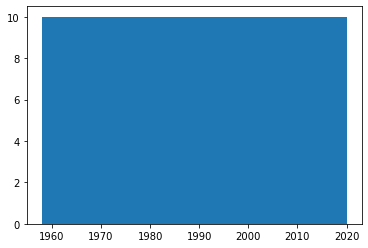

In [7]:
plt.hist(x=top10_df.Year, bins= 63)

## Lyrics scraping:
We get the lyrics for the top_10 songs from Genius API.

We notice that some songs list 2 names of performers, some other list 2 titles (title1/title2), which leads to various errors in the scraping of the lyrics from Genius. So we make some updates:

In [8]:
def update_performer(performer):
    try:
        if performer.find("duet with") > 0:
            performer = performer.split("duet with", 1)[0] #take the performer_1 in "performer_1 duet with performer_2"
        elif performer.find("with") > 0:
            performer = performer.split("with", 1)[0] #take the performer_1 in "performer_1 with performer_2"
        elif performer.find("and") > 0:
            performer = performer.split("and", 1)[0]
        elif performer.find("&") > 0:
            performer = performer.split("&", 1)[0]
        elif performer.find("featuring") > 0:
            performer = performer.split("featuring", 1)[0]
        elif performer.find("feat") > 0:
            performer = performer.split("feat", 1)[0]
    except:
        print("Error:", performer)
        
    return performer

In [9]:
top10_df['Performer'] = top10_df['Performer'].str.lower()

top10_df['Performer'] = top10_df.apply(lambda x: update_performer(x['Performer']), axis=1)

In [10]:
def update_song(title):
    try:
        if title.find("/") > 0:
            title = title.split("/", 1)[0] #take the title_1 in "title_1/title_2"
    except:
        print("Error:", title)
        
    return title

In [11]:
top10_df['Song'] = top10_df['Song'].str.lower()

top10_df['Song'] = top10_df.apply(lambda x: update_song(x['Song']), axis=1)

We save the lyrics of each song in a column **Lyrics**.

In [12]:
token = 'vLxzP-1gpCyF2ZwDa_Sfjk1gm9WlA7yVVgRFFpRO6wyIH72DA8sOEynW7jj1aYKh'

genius = lg.Genius(token, 
                   skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], 
                   remove_section_headers=True) #ignore metadata

In [13]:
"""
@params: a song title and the performer's name
@return: the lyrics, or "Error" in case of exception
"""
def get_lyrics(song, performer):
    try:
        return genius.search_song(song, performer).lyrics
    except: 
        return "Error"

In [14]:
top10_df['Lyrics'] = top10_df.apply(lambda x: get_lyrics(x['Song'],x['Performer']), axis=1)

Searching for "eastside" by benny blanco, halsey ...
Done.
Searching for "wait for you" by elliott yamin...
Done.
Searching for "wildflower" by skylark...
Done.
Searching for "even though i'm leaving" by luke combs...
Done.
Searching for "do re mi" by blackbear...
Done.
Searching for "you make it easy" by jason aldean...
Done.
Searching for "smack that" by akon ...
Done.
Searching for "alley-oop" by hollywood argyles...
Done.
Searching for "quiet village" by the exotic sounds of martin denny...
Done.
Searching for "the ballad of the green berets" by ssgt barry sadler...
Done.
Searching for "run this town" by jay-z, rihanna ...
Done.
Searching for "poor side of town" by johnny rivers...
Done.
Searching for "blue moon" by the marcels...
Done.
Searching for "burning bridges" by jack scott...
Done.
Searching for "take a bow" by rihanna...
Done.
Searching for "classical gas" by mason williams...
Specified song does not contain lyrics. Rejecting.
Searching for "suspicion" by terry stafford..

In [15]:
top10_df.query('Lyrics=="Error"')

,Song,Performer,Year,Decade,Lyrics
36994,classical gas,mason williams,1968,1960,Error
36712,"can't help falling in love (from ""sliver"")",ub40,1993,1990,Error
36771,out of limits,the marketts,1964,1960,Error
36561,calcutta,lawrence welk,1961,1960,Error
38603,because they're young,duane eddy,1960,1960,Error
20571,outa-space,billy preston,1972,1970,Error
20570,pipeline,chantay's,1963,1960,Error
20492,pick up the pieces,awb,1975,1970,Error
20802,scorpio,dennis coffey & the detroit guitar b,1971,1970,Error
20766,tea for two cha cha,the tommy dorsey orchestra,1958,1950,Error


In [16]:
print("Total number of errors: ", len(top10_df.query('Lyrics=="Error"')))

Total number of errors:  19


The number of erronous lyrics is low, we can simply drop them.

In [17]:
top10_df = top10_df.drop(top10_df[top10_df.Lyrics=="Error"].index)

We save the final dataframe to a csv file.

In [18]:
filename = "lyrics_per_song.csv"
out_file = open(FOLDER+filename, "w")

top10_df.to_csv(out_file, index=False)

We write the lyrics of the songs from the same decade in a separate file.

In [20]:
for dec in top10_df.Decade.unique():
    filename = "%s_lyrics.txt" % dec
    file = open(FOLDER+filename, 'w')
    _df = top10_df.query("Decade == @dec")
    for l in _df.Lyrics:
        file.write(l)

# ---
<br> We notice wrong results of Genius queries. Here is an example:

In [22]:
top10_df[top10_df['Lyrics'].str.contains("What parallel courses did Bloom and Stephen follow returning?")]

,Song,Performer,Year,Decade,Lyrics
36911,quiet village,the exotic sounds of martin denny,1959,1950,What parallel courses did Bloom and Stephen fo...


This is the text written in file 1950_lyrics.txt:

In [25]:
song = "quiet village"
performer = "the exotic sounds of martin denny"
genius.search_song(song, performer).lyrics

Searching for "quiet village" by the exotic sounds of martin denny...
Done.


"What parallel courses did Bloom and Stephen follow returning?\nStarting united both at normal walking pace from Beresford place they followed in the order named Lower and Middle Gardiner streets and Mountjoy square, west: then, at reduced pace, each bearing left, Gardiner's place by an inadvertance as far as the farther corner of Temple street, north: then at reduced pace with interruptions of halt, bearing right, Temple street, north, as far as Hardwicke place. Approaching, disparate, at relaxed walking pace they crossed both the circus before George's church diametrically, the chord in any circle being less than the arc which it subtends.\nOf what did the duumvirate deliberate during their itinerary?\nMusic, literature, Ireland, Dublin, Paris, friendship, woman, prostitution, diet, the influence of gaslight or the light of arc and glow-lamps on the growth of adjoining paraheliotropic trees, exposed corporation emergency dustbuckets, the Roman catholic church, ecclesiastical celibacy

Whereas the correct lyrics should be the following (small) text:

In [26]:
song = "quiet village"
performer = "martin denny"
genius.search_song(song, performer).lyrics

Searching for "quiet village" by martin denny...
Done.


"Alone in my quiet village I pray\nYou will be returning one day\nTo me\nReturn to me\nAlone living with the mem'ry of you\nPromising you'd always be true\nTo me\nBe true to me\nAbove me there's a moon on fire\nTelling you to love me as I desire\nAnd ever the flame in my quiet village will burn\nDarling till the day you return to me\nReturn to me, return to me"

However we cannot fix such errors automatically, and it's not a good idea to do it manually because we can't know how many of them exist.